# Clairvoyante


In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('../')

In [3]:
#import clairvoyante as cv
import clairvoyante.utils as utils
import clairvoyante.clairvoyante as cv

Shell script example to get testing data from a BAM file and a VCF file
These scripts depend on "samtools" to parse alignment records. 

```
python ../dataPrepScripts/ExtractVariantCandidates.py --bam_fn ../testingData/chr21/hg38.NA12878-WashU_chr21-14069662-46411975.bam --ref_fn ../testingData/chr21/chr21.fa --pi_fn pi_chr21 --ctgName chr21

python ../dataPrepScripts/CreateTensor.py --bam_fn ../testingData/chr21/hg38.NA12878-WashU_chr21-14069662-46411975.bam --pi_fn pi_chr21 --ctgName chr21 --ref_fn ../testingData/chr21/chr21.fa --tensor_fn tensor_chr21

python ../dataPrepScripts/GetTruth.py --vcf_fn ../testingData/chr21/chr21.vcf --var_fn var_chr21 --ctgName chr21
```

## Training using Chr21 variant calls

In [4]:
# load the generate alignment tensors 
# we use only variants overlapping with the regions defined in `CHROM21_v.3.3.2_highconf_noinconsistent.bed`

XArray, YArray, posArray = \
utils.GetTrainingArray("../training/tensor_chr21", 
                       "../training/var_chr21", 
                       "../testingData/chr21/CHROM21_v.3.3.2_highconf_noinconsistent.bed",
                       "chr21")

In [5]:
print XArray.shape
print YArray.shape

(54861, 15, 4, 4)
(54861, 9)


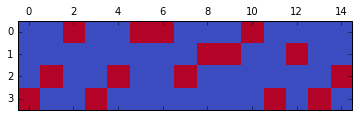

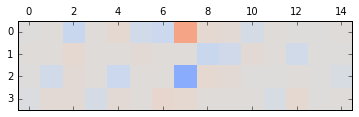

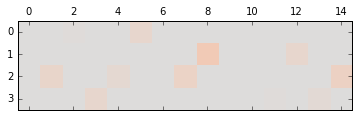

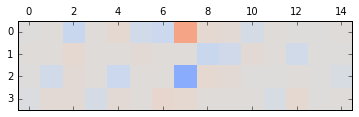

In [6]:
# here we show how the three matrices are like for a candidate site

i = 3721
figure(figsize=(6, 2))
matshow(XArray[i,:,:,0].transpose(), vmin=0, vmax=50, cmap=cm.coolwarm, fignum=0)
figure(figsize=(6, 2))
matshow(XArray[i,:,:,1].transpose(), vmin=-50, vmax=50, cmap=cm.coolwarm, fignum=0)
figure(figsize=(6, 2))
matshow(XArray[i,:,:,2].transpose(), vmin=-50, vmax=50, cmap=cm.coolwarm, fignum=0)
figure(figsize=(6, 2))
matshow(XArray[i,:,:,3].transpose(), vmin=-50, vmax=50, cmap=cm.coolwarm, fignum=0)

In [7]:
%%bash
mkdir -p ../training/parameters

In [8]:
# create a Clairvoyante
m = cv.Clairvoyante()
m.init()

In [9]:
# training and save the parameters, we train on the first 80% SNP sites and validate on other 20% SNP sites
batchSize = 1000
validationLosts = []
XLen = len(XArray)
XIdx = int(XLen * 0.8)
epoch = 0
for i in range(1, int(XIdx/batchSize)*60+1):
    XBatch, YBatch = utils.GetBatch(XArray[:XIdx], YArray[:XIdx], size=batchSize)
    loss = m.train(XBatch, YBatch)
    if i % int(XIdx / batchSize) == 0:
        validationLost = m.getLoss( XArray[XIdx:-1], YArray[XIdx:-1] )
        print >> sys.stderr, i,\
                 "Training lost:", loss/batchSize,\
                 "Validation lost: ", validationLost/(XLen-XIdx)
        m.saveParameters('../training/parameters/cv.params-%05d' % i)
        validationLosts.append( (validationLost, i) )
        if epoch and epoch % 20 == 0:
            nl = m.setLearningRate()
            print >> sys.stderr, "New learning rate: %.2e" % nl
        epoch += 1
        

43 Training lost: 1.208609375 Validation lost:  1.11404626697
86 Training lost: 0.856809814453 Validation lost:  0.820096504631
129 Training lost: 0.613249023437 Validation lost:  0.601864911316
172 Training lost: 0.514970336914 Validation lost:  0.476326035354
215 Training lost: 0.427604736328 Validation lost:  0.41937498932
258 Training lost: 0.39278314209 Validation lost:  0.375655061358
301 Training lost: 0.446072875977 Validation lost:  0.339337246644
344 Training lost: 0.334375061035 Validation lost:  0.30790224443
387 Training lost: 0.268884033203 Validation lost:  0.248579298691
430 Training lost: 0.248494293213 Validation lost:  0.223824111242
473 Training lost: 0.211046157837 Validation lost:  0.202377693401
516 Training lost: 0.215674163818 Validation lost:  0.192672185777
559 Training lost: 0.23413684082 Validation lost:  0.181043456097
602 Training lost: 0.140851196289 Validation lost:  0.174358101277
645 Training lost: 0.171062713623 Validation lost:  0.179492730381
688 T

In [10]:
# pick the parameter set of the smallest validation loss

validationLosts.sort()
i = validationLosts[0][1]
print i
m.restoreParameters('../training/parameters/cv.params-%05d' % i)

1978
INFO:tensorflow:Restoring parameters from ../training/parameters/cv.params-01978


INFO:tensorflow:Restoring parameters from ../training/parameters/cv.params-01978


## Testing using Chr22 variant calls

In [11]:
XArray2, YArray2, posArray2 = \
utils.GetTrainingArray("../training/tensor_chr22", 
                       "../training/var_chr22", 
                       "../testingData/chr22/CHROM22_v.3.3.2_highconf_noinconsistent.bed",
                       "chr22")

In [12]:
batchSize = 1000
bases, ts = m.predict(XArray2[0:batchSize])

for i in range(batchSize, len(XArray2), batchSize):
    base, t = m.predict(XArray2[i:i+batchSize])
    bases = np.append(bases, base, 0)
    ts = np.append(ts, t, 0)

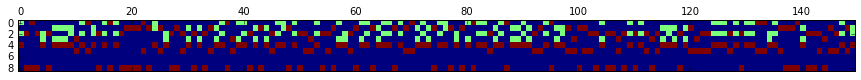

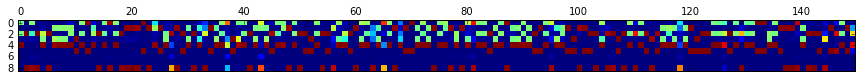

In [13]:
# we can compare the output of the expected calls and the predicted calls

figure(figsize=(15, 5))
matshow(YArray2[4000:4150,:].transpose(), fignum=0)
figure(figsize=(15, 5))
matshow(np.concatenate( (bases[4000:4150,:],ts[4000:4150,:]),1).transpose(), fignum=0)


## Evaluation

In [14]:
ed = []
for pos, predictV, annotateV in zip(np.array(posArray2), ts, YArray2[:,4:]):
    ed.append( (pos, np.argmax(predictV), np.argmax(annotateV)) )
ed = np.array(ed)

In [15]:
from collections import Counter

In [16]:
for i in range(5):
    cnt = Counter(ed[ed[:,2]==i,1])
    print i,"\t",
    for j in range(5):
        print cnt.get(j,0),"\t",
    print

0 	23226 	142 	0 	0 	343 	
1 	90 	10510 	0 	0 	26 	
2 	69 	18 	0 	0 	182 	
3 	2 	0 	0 	0 	29 	
4 	370 	28 	0 	0 	14141 	


In [17]:
print "Recall rate for het-call (regardless called variant types):", 1.0*sum((ed[:,1]!=4) & (ed[:,2]==0))/sum(ed[:,2]==0)
print "Recall rate for het-call (called variant type = het):",       1.0*sum((ed[:,1]==0) & (ed[:,2]==0))/sum(ed[:,2]==0)
print
print "PPV for het-call (regardless called variant types):", 1.0*sum((ed[:,1]==0) & (ed[:,2]!=4))/sum(ed[:,1]==0)
print "PPV for het-call (called variant type = het):",       1.0*sum((ed[:,1]==0) & (ed[:,2]==0))/sum(ed[:,1]==0)
print
print "Recall rate for hom-call (regardless called variant types):", 1.0*sum((ed[:,1]!=4) & (ed[:,2]==1))/sum(ed[:,2]==1)
print "Recall rate for hom-call (called variant type = hom):",       1.0*sum((ed[:,1]==1) & (ed[:,2]==1))/sum(ed[:,2]==1)
print
print "PPV for hom-call (regardless called variant types):", 1.0*sum((ed[:,1]==1) & (ed[:,2]!=4))/sum(ed[:,1]==1)
print "PPV for hom-call (called variant type = hom):",       1.0*sum((ed[:,1]==1) & (ed[:,2]==1))/sum(ed[:,1]==1)
print
print "Recall rate for all calls:", 1.0*sum((ed[:,1]!=4) & (ed[:,2]!=4))/sum(ed[:,2]!=4) 
print "PPV for all calls:",         1.0*sum((ed[:,1]!=4) & (ed[:,2]!=4))/sum(ed[:,1]!=4) 

Recall rate for het-call (regardless called variant types): 0.985534140272
Recall rate for het-call (called variant type = het): 0.979545358694

PPV for het-call (regardless called variant types): 0.984425642968
PPV for het-call (called variant type = het): 0.977648693017

Recall rate for hom-call (regardless called variant types): 0.997553171466
Recall rate for hom-call (called variant type = hom): 0.989083380388

PPV for hom-call (regardless called variant types): 0.997382688353
PPV for hom-call (called variant type = hom): 0.982426621798

Recall rate for all calls: 0.983254900829
PPV for all calls: 0.988448701204
